# The potassium problem (solved)

2025-03-25    

## How can a potassium map show up without a corresponding hotmax peak?     

I thought that there was a very serious problem with the  *hotmax* peak scanning approach of the `maxrf4u` package. In the case of complex objects with a large number of elements present, it seems to be the case we do not locate all peaks , due to shadowing by other peaks. Let's take a look again at our page 01 datastack... 

In [11]:
from glob import glob
import maxrf4u as mx 
import numpy as np 
import matplotlib.pyplot as plt 
import moseley as mos

In [3]:
datastack_file = '/home/frank/Work/DATA/falnama-data/WM-71803-01_400_600_50.datastack'

In [4]:
ds = mx.DataStack(datastack_file)

In [5]:
ds.tree()

/
├── compton_peak_energy (1,) float64
├── hotmax_baselines (32, 4096) float64
├── hotmax_noiselines (32, 4096) float64
├── hotmax_peak_idxs_flat (33,) int64
├── hotmax_peak_idxs_list (32, 2) int64
├── hotmax_spectra (32, 4096) float32
├── hotmax_spots (32, 2) int64
├── hotmax_subpeak_idxs_list (32, 19) int64
├── imvis_extent (4,) int64
├── imvis_reg (583, 355, 3) uint8
├── imvis_reg_ (583, 355, 3) uint8
├── imvis_reg_highres (8256, 5027, 3) uint8
├── imvis_reg_highres_ (8256, 5027, 3) uint8
├── maxrf_cube (583, 355, 4096) float32
├── maxrf_energies (4096,) float64
├── maxrf_maxspectrum (4096,) float32
├── maxrf_sumspectrum (4096,) float64
├── nmf_atomnums (18,) int64
├── nmf_elementmaps (18, 583, 355) float32
├── nmf_gausscomponents (34, 4096) float32
├── nmf_peakmaps (34, 583, 355) float32
└── nmf_peaks2elements_matrix (18, 33) float32

/home/frank/Work/DATA/falnama-data/WM-71803-01_400_600_50.datastack:




In [6]:
hma = mx.HotmaxAtlas(datastack_file)

In [32]:
%matplotlib widget

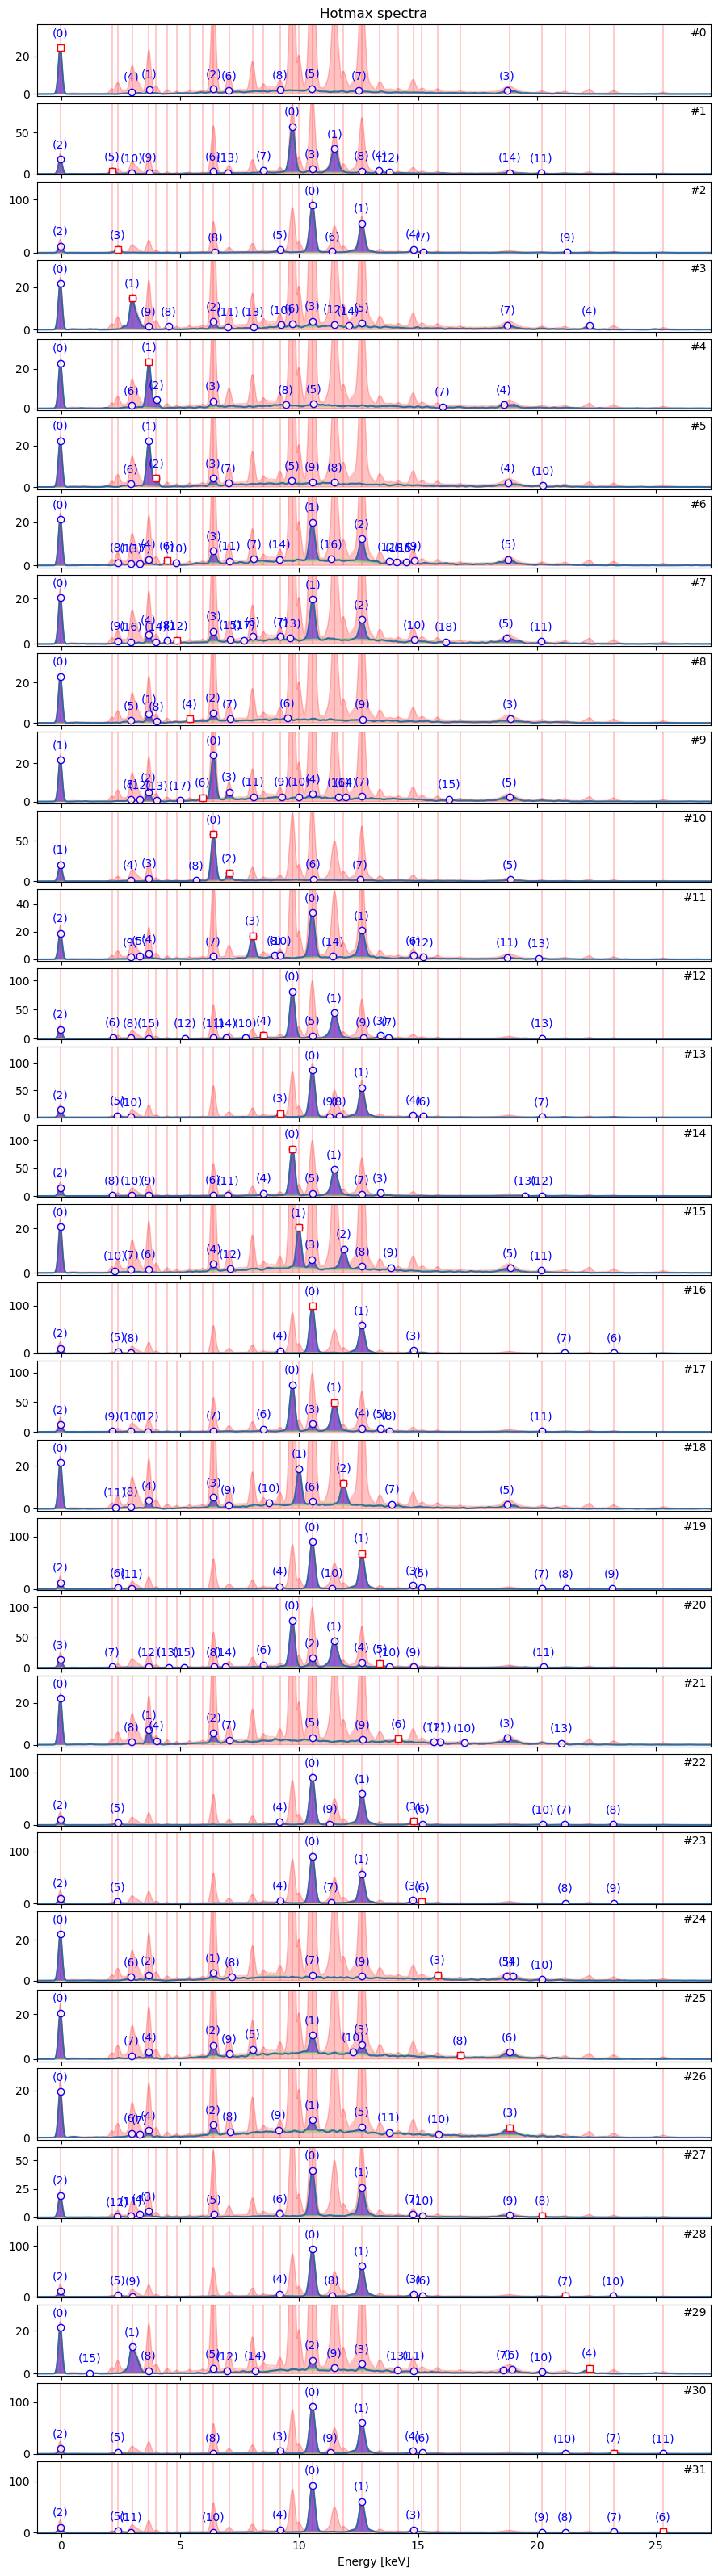

In [64]:
hma.plot_spectra(svg=False)

In [65]:
n = hma.finder('K')
n

False

**Indeed, we can not find potassium. Why is that?** 

In [94]:
elems = ['Au', 'K', 'Sn', 'Ar'] #['Ca', 'K', 'Sn', 'Pb', 'Zr', 'Au']
xfs = [mos.XFluo(elem, 23) for elem in elems]

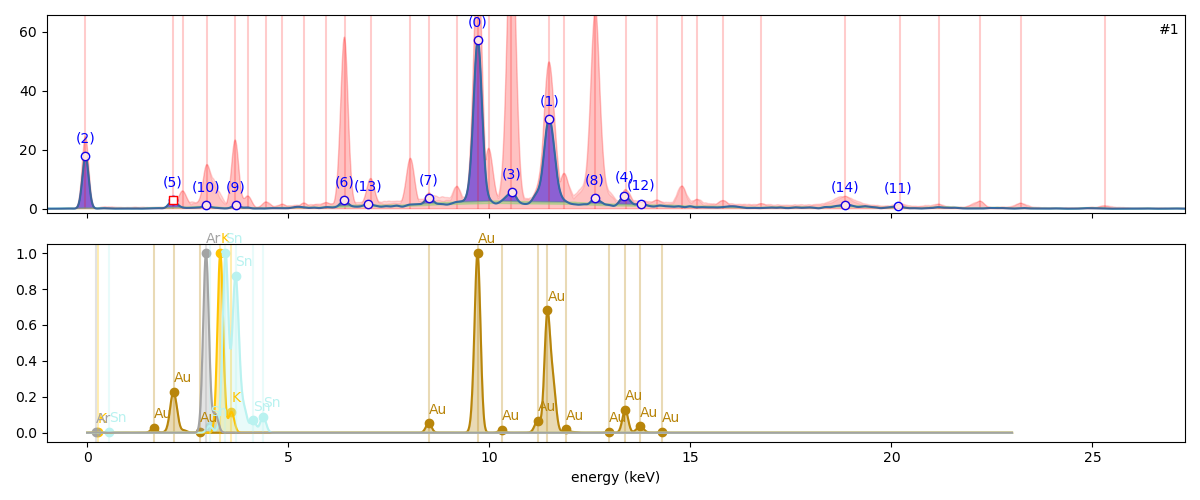

In [95]:
fig, axs = plt.subplots(nrows=2, figsize=[12, 5], sharex=True)
ax0, ax1 = axs.flatten()
hma.plot_spectrum(1, ax=ax0)
for xf in xfs: 
    xf.plot(ax=ax1)


In [149]:
%matplotlib inline

Please wait while initializing peak pattern atlas...


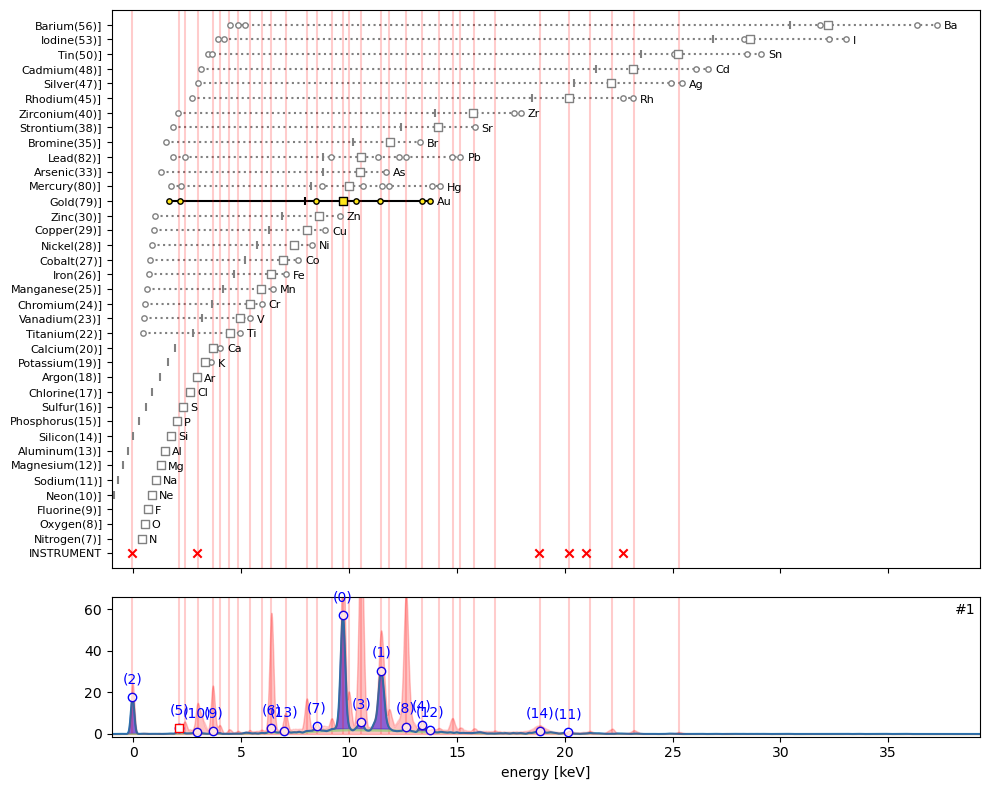

In [68]:
ppa = mx.Peak_Pattern_Atlas(datastack_file=datastack_file)
ppa.update_eoi(['Ar', 'Zr', 'Rh'])
ppa.plot_puzzle(1, select_elems=elems)

Let's take a look again at the potassium map, and then plot the average spectrum for a blue region.

In [150]:
emaps = ds.read('nmf_elementmaps') 

In [151]:
atomnums = ds.read('nmf_atomnums')

In [152]:
nmf_elements = mx.elems_from_atomnums(atomnums)
i = nmf_elements.index('K')
K_map = emaps[i]
print(nmf_elements)

['S', 'Ag', 'K', 'Ca', 'Ba', 'Ti', 'Cr', 'Mn', 'Fe', 'Ni', 'Cu', 'Zn', 'Au', 'Hg', 'As', 'Pb', 'Sr', 'Zr']


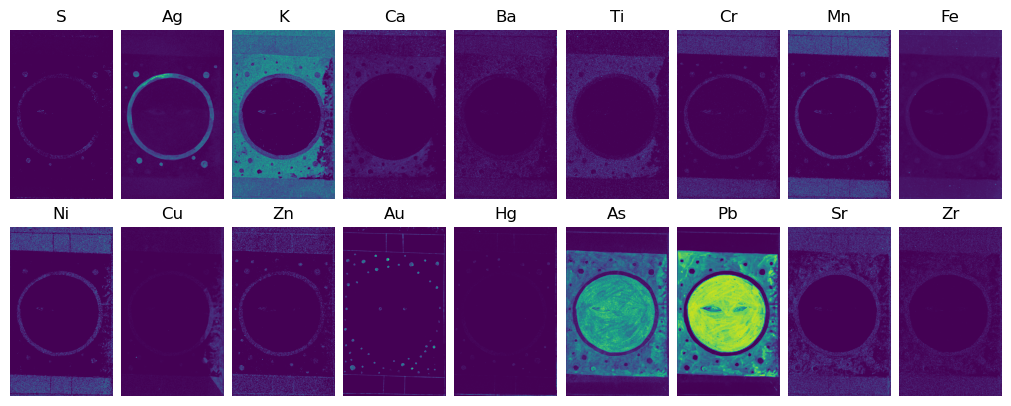

In [155]:
fig, axs = plt.subplots(nrows=2, ncols=9, figsize=[10, 7], layout='compressed') 
axs = axs.flatten()

for i, ax in enumerate(axs):
    ax.imshow(emaps[i])
    ax.set_title(nmf_elements[i])
    ax.set_axis_off()

This is weird. Let's take a look at the average spectrum in the blue region...

In [99]:
imvis = ds.read('imvis_reg_highres')
extent = ds.read('imvis_extent') 

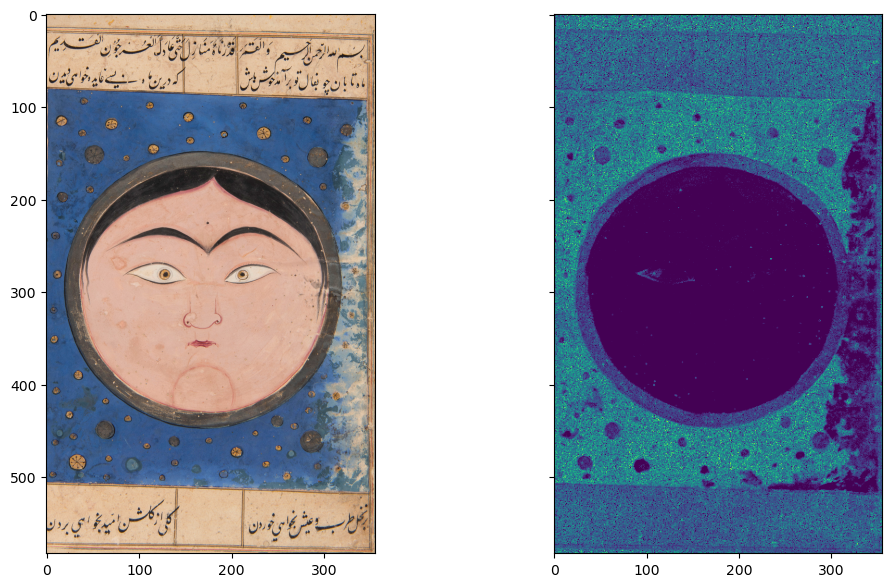

In [156]:
fig, axs = plt.subplots(ncols=2, figsize=[12, 7], sharex=True, sharey=True)
ax0, ax1 = axs.flatten()

ax0.imshow(imvis, extent=extent)
ax1.imshow(K_map)

In [98]:
cube = ds.read('maxrf_cube', compute=False)

In [104]:
blue_cube = cube[105:130, 95:120]
blue_cube.shape

(25, 25, 4096)

In [105]:
mean_spectrum = np.mean(blue_cube.reshape(-1, 4096), axis=0)
mean_spectrum.shape

(4096,)

In [109]:
x_keV = ds.read('maxrf_energies')
y_max = ds.read('maxrf_maxspectrum')

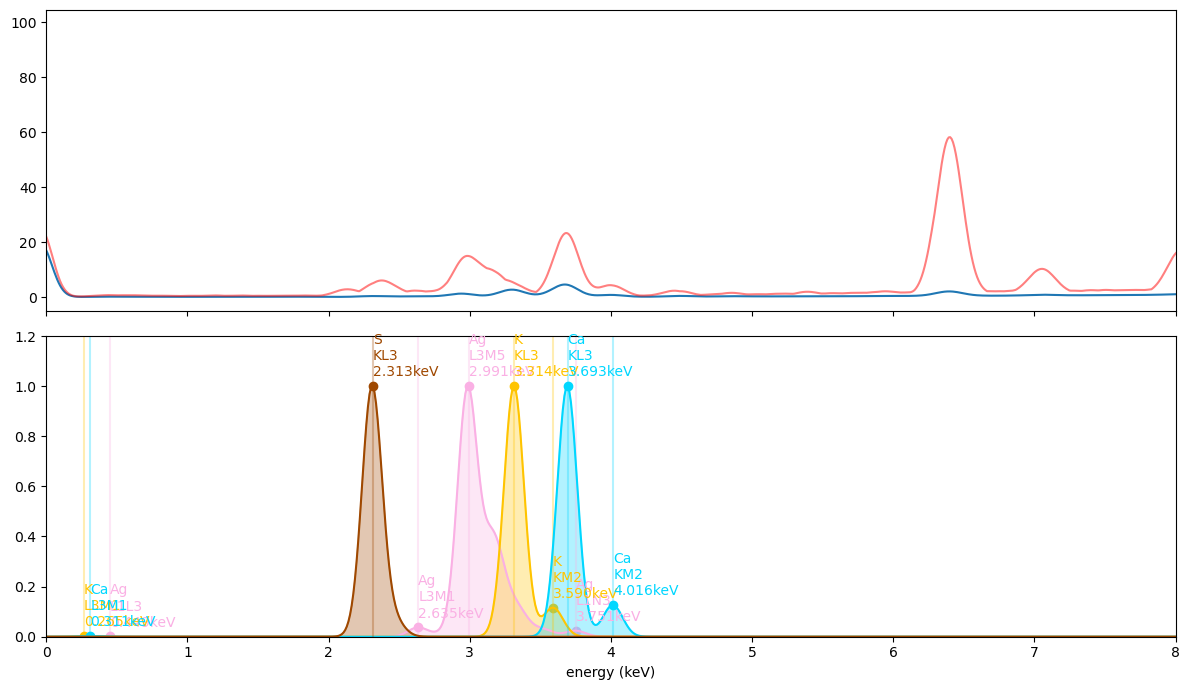

In [157]:
elems = ['Ag', 'K', 'Ca', 'S']
xfs = [mos.XFluo(elem, 23) for elem in elems] 

fig, axs = plt.subplots(nrows=2, figsize=[12, 7], sharex=True)
ax0, ax1 = axs.flatten()

ax0.plot(x_keV, mean_spectrum)
ax0.plot(x_keV, y_max, color='r', alpha=0.5)
ax1.set_ylim(0, 1.2)
ax1.set_xlim(0, 8)
for xf in xfs:
    xf.plot(ax=ax1, peak_labels='full') 


Ok, this is more clear now. Potassium (K) is tiny signal that only cause a slight shoulder on the silver peak. It is therefore not detected in the max spectrum. Let's see how the 'argon map' will look like. 

In [158]:
els, element_maps = mx.compute_nmf_element_maps(datastack_file, ['K', 'Ag', 'Ca'])

Preparing peaks to elements transformation matrix...
Computing element maps for ['Ag', 'K', 'Ca']...


/home/frank/anaconda3/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Ready computing!



Write NMF element maps and factorization data to datastack file [y/n]?  n


In [159]:
els

['Ag', 'K', 'Ca']

In [160]:
argon_map, K_map, Ca_map = element_maps

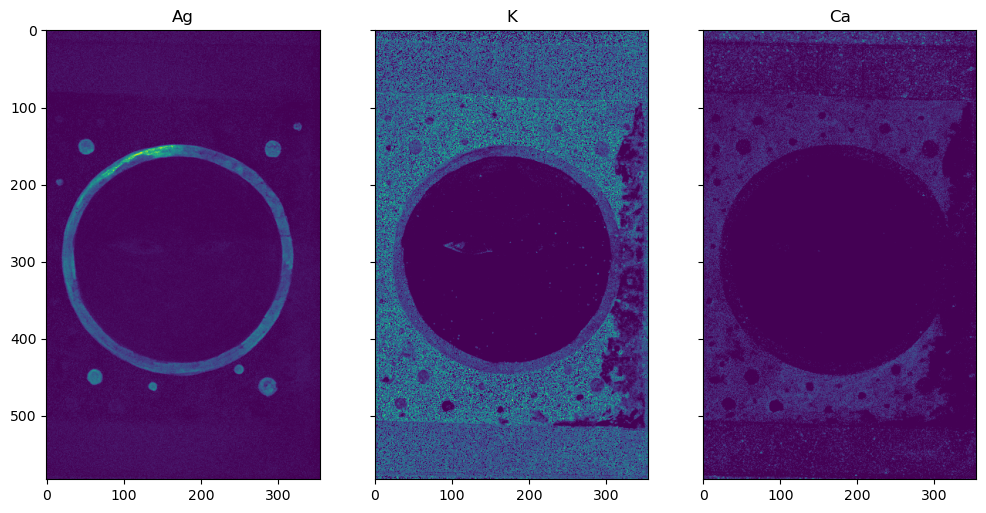

In [161]:
fig, axs = plt.subplots(ncols=3, figsize=[12, 7], sharex=True, sharey=True)
axs = axs.flatten()

for ax, emap, el in zip(axs, element_maps, els): 
    ax.imshow(emap)
    ax.set_title(el)

In [123]:
plt.close('all')

Ok, conclusion is that even when not hotmax peak, but only a very light shoulder on the silver K_La is located at the K_Ka, the peak map is still computed correctly. The speckles are a result of the overlap of K_Kb with Ca_Ka. Without including Ca in the list the result is more smooth.  